In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
├─Layer: 1-2                             --                        --                        --  

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:157: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [4]:
train_transforms = A.Compose(
    [
        A.augmentations.crops.transforms.CropAndPad(-4, p=0.5),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([
    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [5]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


Show sample Images from the dataset

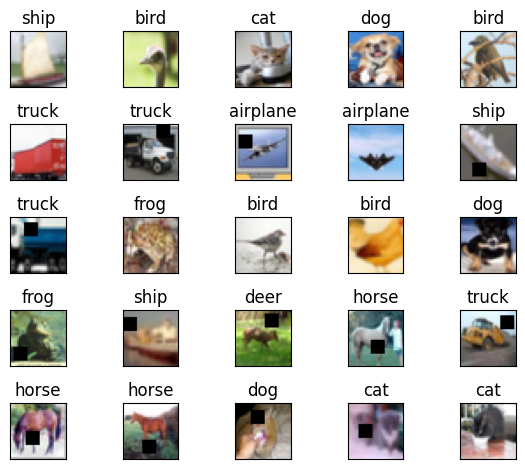

In [6]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.93E-02


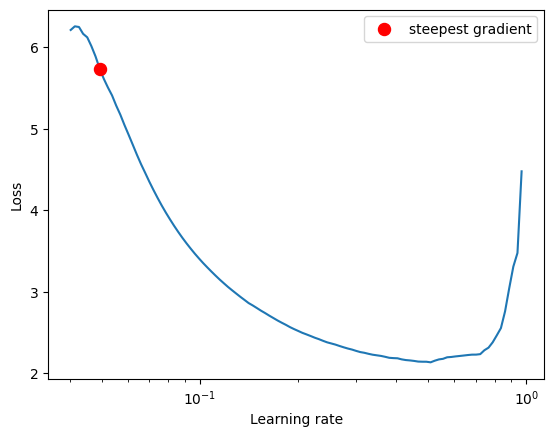

In [7]:
drop_out = 0.05
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10, drop_out_probability = drop_out).to(device)
criterion = nn.CrossEntropyLoss()
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'#, verbose=True
        )
    return scheduler

max_lr = 4.93E-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()
    lr_values.append(optim_obj.optimizer.param_groups[0]['lr'])


epoch: 1


loss=1.3667913675308228 batch_id=97 Accuracy = 41.43: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.0031, Accuracy: 4734/10000 (47.34%)

epoch: 2


loss=0.9661774635314941 batch_id=97 Accuracy = 57.09: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]



Test set: Average loss: 0.0022, Accuracy: 6095/10000 (60.95%)

epoch: 3


loss=1.0132380723953247 batch_id=97 Accuracy = 66.21: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]



Test set: Average loss: 0.0021, Accuracy: 6430/10000 (64.30%)

epoch: 4


loss=1.0290714502334595 batch_id=97 Accuracy = 70.57: 100%|██████████| 98/98 [00:24<00:00,  3.93it/s]



Test set: Average loss: 0.0027, Accuracy: 5969/10000 (59.69%)

epoch: 5


loss=0.8861659169197083 batch_id=97 Accuracy = 70.82: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]



Test set: Average loss: 0.0023, Accuracy: 6370/10000 (63.70%)

epoch: 6


loss=0.8717733025550842 batch_id=97 Accuracy = 70.50: 100%|██████████| 98/98 [00:24<00:00,  3.99it/s]



Test set: Average loss: 0.0021, Accuracy: 6187/10000 (61.87%)

epoch: 7


loss=0.8760225176811218 batch_id=97 Accuracy = 71.93: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0026, Accuracy: 5976/10000 (59.76%)

epoch: 8


loss=0.8969663977622986 batch_id=97 Accuracy = 73.09: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0020, Accuracy: 6723/10000 (67.23%)

epoch: 9


loss=0.7815045118331909 batch_id=97 Accuracy = 73.38: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]



Test set: Average loss: 0.0016, Accuracy: 7237/10000 (72.37%)

epoch: 10


loss=0.6690949201583862 batch_id=97 Accuracy = 73.97: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]



Test set: Average loss: 0.0018, Accuracy: 6813/10000 (68.13%)

epoch: 11


loss=0.7744773626327515 batch_id=97 Accuracy = 74.77: 100%|██████████| 98/98 [00:24<00:00,  4.05it/s]



Test set: Average loss: 0.0016, Accuracy: 7196/10000 (71.96%)

epoch: 12


loss=0.6543551087379456 batch_id=97 Accuracy = 75.34: 100%|██████████| 98/98 [00:24<00:00,  4.06it/s]



Test set: Average loss: 0.0022, Accuracy: 6457/10000 (64.57%)

epoch: 13


loss=0.6013375520706177 batch_id=97 Accuracy = 75.70: 100%|██████████| 98/98 [00:24<00:00,  4.02it/s]



Test set: Average loss: 0.0024, Accuracy: 6118/10000 (61.18%)

epoch: 14


loss=0.5649464130401611 batch_id=97 Accuracy = 76.20: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.0014, Accuracy: 7581/10000 (75.81%)

epoch: 15


loss=0.6936125159263611 batch_id=97 Accuracy = 77.14: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]



Test set: Average loss: 0.0017, Accuracy: 6962/10000 (69.62%)

epoch: 16


loss=0.7575997114181519 batch_id=97 Accuracy = 78.22: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]



Test set: Average loss: 0.0021, Accuracy: 6651/10000 (66.51%)

epoch: 17


loss=0.6125018000602722 batch_id=97 Accuracy = 79.04: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.0013, Accuracy: 7853/10000 (78.53%)

epoch: 18


loss=0.6537100076675415 batch_id=97 Accuracy = 79.85: 100%|██████████| 98/98 [00:23<00:00,  4.08it/s]



Test set: Average loss: 0.0015, Accuracy: 7603/10000 (76.03%)

epoch: 19


loss=0.489517480134964 batch_id=97 Accuracy = 80.57: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0011, Accuracy: 8071/10000 (80.71%)

epoch: 20


loss=0.49825596809387207 batch_id=97 Accuracy = 81.96: 100%|██████████| 98/98 [00:24<00:00,  4.07it/s]



Test set: Average loss: 0.0010, Accuracy: 8224/10000 (82.24%)

epoch: 21


loss=0.47060734033584595 batch_id=97 Accuracy = 83.97: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0009, Accuracy: 8419/10000 (84.19%)

epoch: 22


loss=0.4568029046058655 batch_id=97 Accuracy = 85.41: 100%|██████████| 98/98 [00:23<00:00,  4.11it/s]



Test set: Average loss: 0.0009, Accuracy: 8498/10000 (84.98%)

epoch: 23


loss=0.3810807168483734 batch_id=97 Accuracy = 87.78: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.0008, Accuracy: 8648/10000 (86.48%)

epoch: 24


loss=0.41090837121009827 batch_id=97 Accuracy = 89.97: 100%|██████████| 98/98 [00:23<00:00,  4.10it/s]



Test set: Average loss: 0.0007, Accuracy: 8804/10000 (88.04%)



Plot LR values

In [9]:
import matplotlib.pyplot as plt
def plot_lr_values(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    plt.yscale('log')
    plt.show()

Plot results for Batch Norm experiment

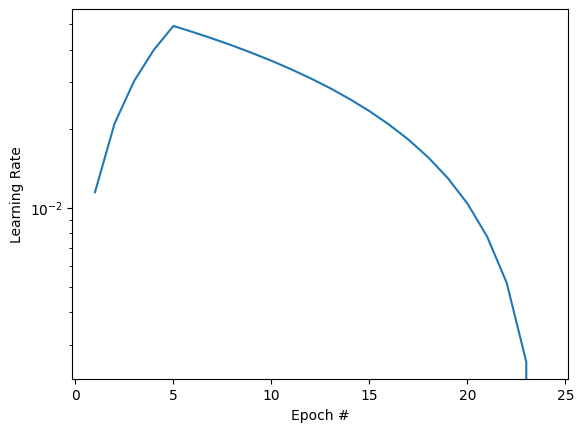

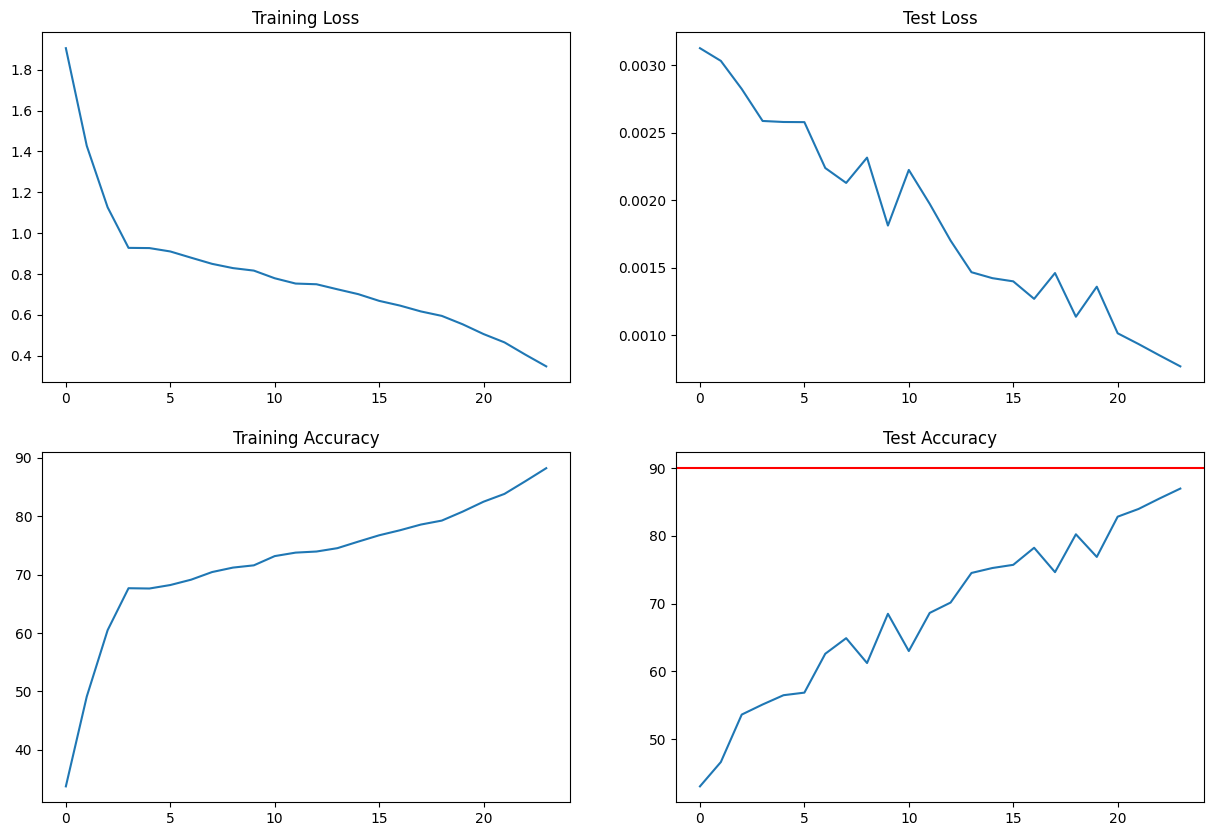

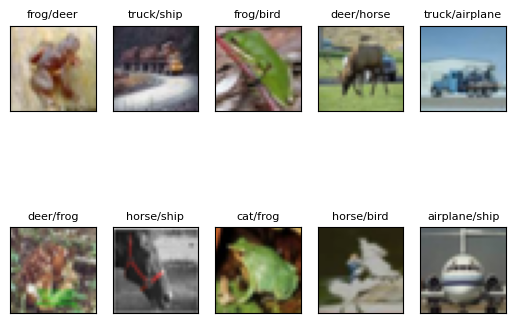

[0.011456957055214722, 0.020941914110429442, 0.030426871165644166, 0.03991182822085889, 0.04927353368421052, 0.046679834736842105, 0.04408613578947368, 0.04149243684210526, 0.03889873789473684, 0.03630503894736842, 0.03371134, 0.031117641052631578, 0.028523942105263156, 0.025930243157894734, 0.023336544210526316, 0.020742845263157898, 0.018149146315789472, 0.01555544736842105, 0.012961748421052632, 0.010368049473684207, 0.007774350526315789, 0.005180651578947364, 0.0025869526315789454, -6.74631578946594e-06]


In [10]:
plot_lr_values(lr_values)
plot_statistics(train_losses, train_acc, test_losses, test_acc, target_test_acc=90.)
incorrect_predictions_bn = get_incorrect_predictions(resnet_model, test_loader, device)
show_incorrect_predictions(incorrect_predictions_bn, class_names, num_rows = 2, num_cols = 5)
print(lr_values)

Print Training Log

In [12]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.4964549577966029 | 0.0025385816574096678 |     47.452     |    55.12     |
|   2   |  1.0287377420736818 |  0.002076111203432083 |     64.166     |    64.71     |
|   3   |  0.8183457389169809 | 0.0019306169033050536 |     72.066     |    67.42     |
|   4   |  0.6978913162435804 | 0.0018616529703140258 |      76.0      |    68.92     |
|   5   |  0.6844441294670105 |  0.002093923342227936 |     76.346     |    64.18     |
|   6   |  0.7075710108085554 | 0.0018084362864494324 |     75.744     |    68.87     |
|   7   |  0.672472074323771  | 0.0017857434809207917 |     76.924     |    69.37     |
|   8   |  0.6400955240337216 |  0.001836242264509201 |     78.008     |    70.85     |
|   9   |  0.6241370488186272 | 